## Weather at the Mauna Kea Canadian-France-Hawaii Telescope

_version 1.0 1/4/2018_

_version 1.1 27/5/2024_


_Wing-Fai Thi_

### Aim of the notebook:
- a few hour horizon weather prediction
- use of the Facebook prophet package

### Requirements:
- Python >= 3.9 with numpy, pandas, matplolib, and sklearn packages installed
- first one has to download Prophet and its dependencies (STAN, Cython, Matplotlib).
- the dataset is provided by the [Mauna Kea Weather Center](http://mkwc.ifa.hawaii.edu/archive/wx/cfht/). I am usig the data gatered at the CFHT.

### Warning:
- The [Mauna Kea Weather Center](http://mkwc.ifa.hawaii.edu/) provides much more accurate predictions. The exercise here is intented to show how to use the Facebook Time Series prediciton package and cannot replace actual predictions by professional meteorologists.

In [12]:
import warnings
warnings.filterwarnings('ignore')
import sys
print(sys.version)

3.9.19 (main, Mar 19 2024, 16:08:27) 
[Clang 15.0.0 (clang-1500.3.9.4)]


In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import pickle # if one wants to save the Phrophet model

In [14]:
# parse the input
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H %M') # year month day hour minute

# combine the 4 columns into a Pandas timestamp+
# The data are in a space-separated table format
dataset = pd.read_table('cfht-wx.2016.dat.txt',
                        delim_whitespace=True, # white space delimiter
                        header=None,             # no header
                        date_parser=parse, # name of the function used to parse the data
                        parse_dates ={'datetime' : [0,1,2,3,4]})


In [15]:
# year month day hour minute(HST) wind_speed(kts) wind_direction(dec) temperature(C) relative_humidity(%) pressure(mb-if present)
columns=['datetime','wind speed','wind direction', # assign a column header
                 'temperature','relative humidity','pressure']
dataset.columns = columns
dataset.dtypes

datetime             datetime64[ns]
wind speed                    int64
wind direction                int64
temperature                 float64
relative humidity             int64
pressure                    float64
dtype: object

In [16]:
dataset.head()

,datetime,wind speed,wind direction,temperature,relative humidity,pressure
0,2016-01-01 00:00:00,19,348,2.05,7,618.4
1,2016-01-01 00:01:00,19,351,2.05,7,618.4
2,2016-01-01 00:02:00,18,0,2.05,7,618.4
3,2016-01-01 00:03:00,17,353,2.05,7,618.4
4,2016-01-01 00:04:00,19,346,2.02,7,618.4


The data are recorded every minutes, which is a pretty high rate. Here for our prediction purpose we make a 60 minute averaging of the data.

In [455]:
# make a 1 hr rolling average
# The first column is the datatime and we will not roll it
nb_minutes = 60
avg_dataset = pd.DataFrame.copy(dataset)
avg_dataset.iloc[:, 1:5]=avg_dataset.iloc[:, 1:5].rolling(nb_minutes).mean()
avg_dataset=avg_dataset.iloc[::nb_minutes, :].dropna()
print(avg_dataset.shape)

(8757, 6)


In [456]:
# alternative
avg_dataset = pd.DataFrame.copy(dataset) # make first a copy of the original data
avg_dataset = avg_dataset.resample('H', on='datetime').mean() # resample to the hourly-average
print(avg_dataset.shape)

(8784, 5)


In [457]:
avg_dataset.reset_index(inplace=True) # move the index as a column inplace
avg_dataset.head()

,datetime,wind speed,wind direction,temperature,relative humidity,pressure
0,2016-01-01 00:00:00,25.300000,330.700000,2.544500,6.283333,618.076667
1,2016-01-01 01:00:00,31.650000,272.600000,2.839833,5.516667,617.520000
2,2016-01-01 02:00:00,29.800000,133.983333,2.738000,5.000000,617.263333
3,2016-01-01 03:00:00,28.483333,25.916667,1.624000,5.733333,617.036667
4,2016-01-01 04:00:00,32.766667,154.383333,1.199667,6.516667,617.041667


We will train the model over a few days. One can try models with different training time.

In [20]:
n_train_hours = 7 * 24 # 1 yr * 24 hrs
horizon = 8
pressure = avg_dataset[['datetime','pressure']]
pressure.columns=['ds', 'y'] # change the headers for prophet
pressure['y'] = np.log(pressure['y'])
n0 = avg_dataset.shape[0]
n1 = n0 - n_train_hours - horizon
n2 = n0 - horizon 
pressure_train = pressure.iloc[n1:n2, :]
pressure_train.shape

(168, 2)

We first instantiate the Prophet class. The predicted value is yhat with yhat_lower abd yhat_upper as upper and lower possible values. Prophet uses the same API than scikit-learn.

In [21]:
from prophet import Prophet
m = Prophet(yearly_seasonality=False, weekly_seasonality=False)
m.fit(pressure_train);

15:37:01 - cmdstanpy - INFO - Chain [1] start processing
15:37:01 - cmdstanpy - INFO - Chain [1] done processing


In [22]:
#future = m.make_future_dataframe(periods=horizon,freq='H')
future  = pressure.iloc[n1:,:]
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
171,2016-12-31 19:00:00,6.417662,6.417209,6.418096
172,2016-12-31 20:00:00,6.418190,6.417598,6.418712
173,2016-12-31 21:00:00,6.418592,6.417814,6.419252
174,2016-12-31 22:00:00,6.418765,6.417761,6.419558
175,2016-12-31 23:00:00,6.418637,6.417406,6.419658


m is a Prophet object and can be plotted with predifined settings by Prophet

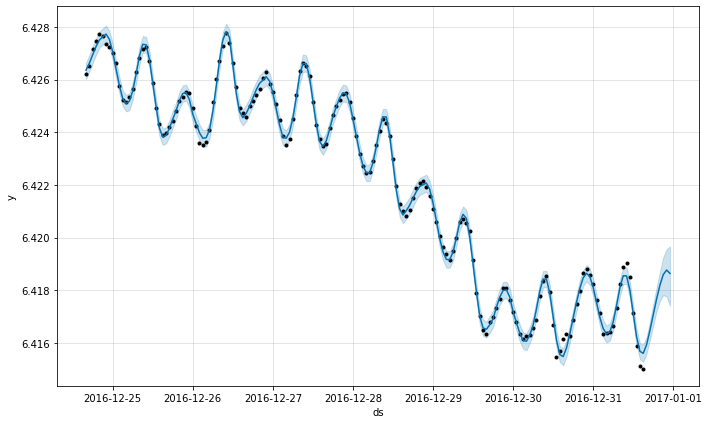

In [23]:
# Pressure forecast with a 8hr horizon
m.plot(forecast);

A time series component decomposition is avaialble. We can clearly see the daily pressure pressure variation. The trend has been a decreasing pressure over the last 7 days.

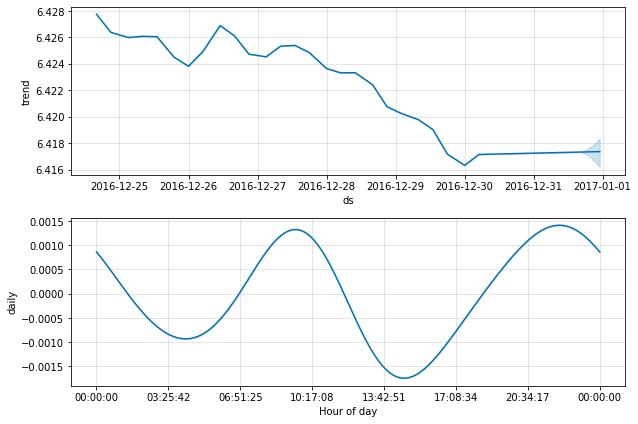

In [24]:
m.plot_components(forecast);

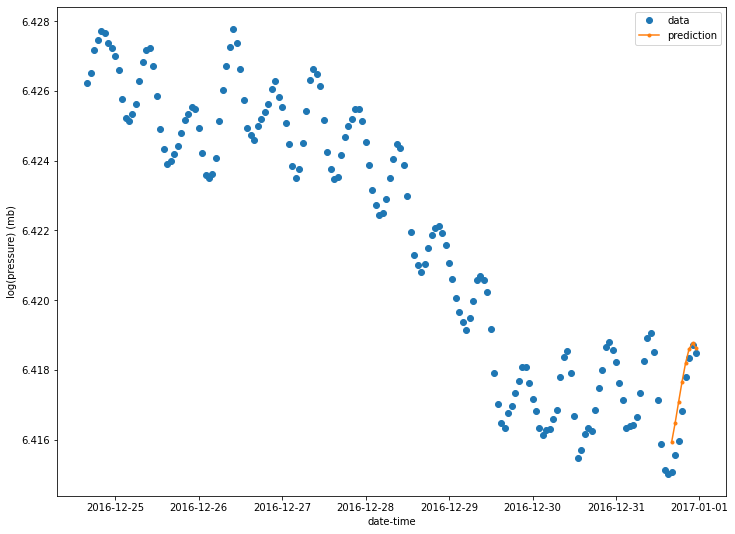

In [25]:
from matplotlib.dates import date2num
t = pressure['ds']
p = pressure['y']
dates  = date2num(t)
datesf = date2num(forecast['ds'])
plt.figure(figsize=(12,9))
plt.plot_date(dates[n1:],p[n1:],marker='o',label='data')
plt.plot_date(datesf[-horizon:],forecast['yhat'][-horizon:],
              marker='.',linestyle='-',label='prediction')
plt.legend()
plt.xlabel('date-time')
plt.ylabel('log(pressure) (mb)')
plt.show()

The 7-day window for the pressure predictions gives reasonable results. 

In [26]:
import math
# compute the mean square error
y_pred = np.array(np.exp(forecast['yhat'][-horizon:]))
y_true = np.array(np.exp(p[-horizon:]))
y_persistent = np.array(np.exp(p[n0-horizon-1:n0-1]))
mse = ((y_pred-y_true)**2).mean()
print('Prediction quality: {:.2f} MSE ({:.2f} RMSE)'.format(mse, math.sqrt(mse)))

Prediction quality: 0.18 MSE (0.42 RMSE)


A persistent model is just using the previous value as a prediction. In our case, the persistent model can predict for the next hour.

In [27]:
mse_persistent = ((y_persistent-y_true)**2).mean()
print('Persistent model quality: {:.2f} MSE ({:.2f} RMSE)'.format(mse_persistent,
                                                                  math.sqrt(mse_persistent)))

Persistent model quality: 0.12 MSE (0.35 RMSE)


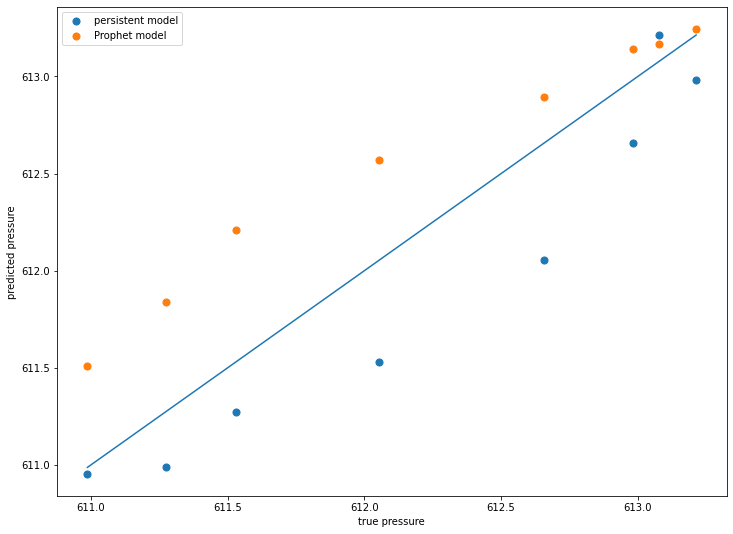

In [28]:
plt.figure(figsize=(12,9))
plt.scatter(y_true,y_persistent,label='persistent model',s=50)
plt.scatter(y_true,y_pred,label='Prophet model',s=50)
plt.plot([y_true.min(),y_true.max()],[y_true.min(),y_true.max()])
plt.xlabel('true pressure')
plt.ylabel('predicted pressure')
plt.legend()
plt.show()

An eight-hour horizon should be really a maximum before the predictions become really bad.

In this notebook, we have learnt how to:
- convert values into a pandas datetime format
- use the Facebook Prophet package to make time series predictions

One can try to predict other meteorological data as well like the temperature.

In [404]:
from pandas import concat

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
 
     Arguments:
     data: Sequence of observations as a list or NumPy array.
     n_in: Number of lag observations as input (X).
     n_out: Number of observations as output (y).
     dropnan: Boolean whether or not to drop rows with NaN values.
     
     Returns:
     Pandas DataFrame of series framed for supervised learning.
     """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [405]:
avg_dataset  # one minute time step

,datetime,wind speed,wind direction,temperature,relative humidity,pressure
0,2016-01-01 00:00:00,25.300000,330.700000,2.544500,6.283333,618.076667
1,2016-01-01 01:00:00,31.650000,272.600000,2.839833,5.516667,617.520000
2,2016-01-01 02:00:00,29.800000,133.983333,2.738000,5.000000,617.263333
3,2016-01-01 03:00:00,28.483333,25.916667,1.624000,5.733333,617.036667
4,2016-01-01 04:00:00,32.766667,154.383333,1.199667,6.516667,617.041667
...,...,...,...,...,...,...
8779,2016-12-31 19:00:00,47.233333,245.716667,-3.656167,46.600000,612.053333
8780,2016-12-31 20:00:00,41.700000,246.200000,-3.339833,45.766667,612.656667
8781,2016-12-31 21:00:00,37.166667,254.966667,-3.423000,48.216667,612.983333
8782,2016-12-31 22:00:00,35.550000,258.333333,-3.314667,44.883333,613.213333


In [420]:
values = avg_dataset.values[:, 1:]
tt =  avg_dataset.values[:, 0]

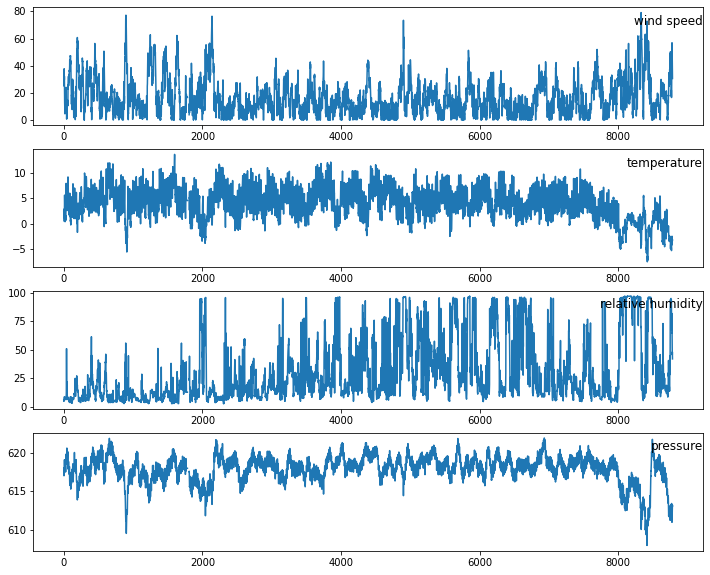

In [421]:
# specify columns to plot
groups = [0, 2, 3, 4]
i = 1
# plot each column
plt.figure(figsize=(12, 10))
for group in groups:
 plt.subplot(len(groups), 1, i)
 plt.plot(values[:, group])
 plt.title(avg_dataset.columns[group + 1], y=0.8, loc='right')
 i += 1
plt.show()

In [422]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
print(values.shape, scaled.shape)

(8784, 5) (8784, 5)


In [484]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, n_out=5)  # prediction for 5 minutes 

In [485]:
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),...,var1(t+3),var2(t+3),var3(t+3),var4(t+3),var5(t+3),var1(t+4),var2(t+4),var3(t+4),var4(t+4),var5(t+4)
1,0.319579,0.934181,0.475940,0.034917,0.722810,0.399789,0.770056,0.489935,0.026764,0.683109,...,0.413895,0.436111,0.412214,0.037398,0.648996,0.448632,0.555603,0.457262,0.041297,0.663735
2,0.399789,0.770056,0.489935,0.026764,0.683109,0.376421,0.378484,0.485109,0.021269,0.664804,...,0.448632,0.555603,0.457262,0.041297,0.663735,0.477053,0.489171,0.451655,0.042538,0.686438
3,0.376421,0.378484,0.485109,0.021269,0.664804,0.359789,0.073211,0.432322,0.029068,0.648639,...,0.477053,0.489171,0.451655,0.042538,0.686438,0.399368,0.072458,0.406220,0.060794,0.740877
4,0.359789,0.073211,0.432322,0.029068,0.648639,0.413895,0.436111,0.412214,0.037398,0.648996,...,0.399368,0.072458,0.406220,0.060794,0.740877,0.373684,0.066102,0.376612,0.063453,0.773446
5,0.413895,0.436111,0.412214,0.037398,0.648996,0.448632,0.555603,0.457262,0.041297,0.663735,...,0.373684,0.066102,0.376612,0.063453,0.773446,0.407158,0.146422,0.471044,0.063098,0.779508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8775,0.657684,0.679708,0.206711,0.839596,0.219541,0.671789,0.678107,0.226748,0.685041,0.214906,...,0.658526,0.697693,0.158536,0.541120,0.255913,0.596632,0.694115,0.182118,0.463665,0.293237
8776,0.671789,0.678107,0.226748,0.685041,0.214906,0.718947,0.678814,0.238041,0.656505,0.217164,...,0.596632,0.694115,0.182118,0.463665,0.293237,0.526737,0.695480,0.197108,0.454803,0.336265
8777,0.718947,0.678814,0.238041,0.656505,0.217164,0.690105,0.682957,0.205866,0.664481,0.237608,...,0.526737,0.695480,0.197108,0.454803,0.336265,0.469474,0.720245,0.193167,0.480858,0.359563
8778,0.690105,0.682957,0.205866,0.664481,0.237608,0.658526,0.697693,0.158536,0.541120,0.255913,...,0.469474,0.720245,0.193167,0.480858,0.359563,0.449053,0.729755,0.198300,0.445409,0.375966


In [486]:
col = [5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21, 22, 23, 25, 26, 27, 28]
reframed.drop(reframed.columns[col], axis=1, inplace=True) # We only predict pressure for 5 minutes

In [487]:
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var5(t),var5(t+1),var5(t+2),var5(t+3),var5(t+4)
1,0.319579,0.934181,0.475940,0.034917,0.722810,0.683109,0.664804,0.648639,0.648996,0.663735
2,0.399789,0.770056,0.489935,0.026764,0.683109,0.664804,0.648639,0.648996,0.663735,0.686438
3,0.376421,0.378484,0.485109,0.021269,0.664804,0.648639,0.648996,0.663735,0.686438,0.740877
4,0.359789,0.073211,0.432322,0.029068,0.648639,0.648996,0.663735,0.686438,0.740877,0.773446
5,0.413895,0.436111,0.412214,0.037398,0.648996,0.663735,0.686438,0.740877,0.773446,0.779508
...,...,...,...,...,...,...,...,...,...,...
8775,0.657684,0.679708,0.206711,0.839596,0.219541,0.214906,0.217164,0.237608,0.255913,0.293237
8776,0.671789,0.678107,0.226748,0.685041,0.214906,0.217164,0.237608,0.255913,0.293237,0.336265
8777,0.718947,0.678814,0.238041,0.656505,0.217164,0.237608,0.255913,0.293237,0.336265,0.359563
8778,0.690105,0.682957,0.205866,0.664481,0.237608,0.255913,0.293237,0.336265,0.359563,0.375966


In [488]:
reframed.shape

(8750, 10)

In [489]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [490]:
# split into train and test sets
refvalues = reframed.values
n_train_hours = 30 * 24
train = refvalues[:n_train_hours, :]
test = refvalues[n_train_hours:, :]
time_test = tt[n_train_hours:]
print(train.shape, test.shape, time_test.shape)

(720, 10) (8030, 10) (8064,)


In [508]:
# split into input and outputs
ny = -5
train_X, train_y = train[:, :ny], train[:, ny:]
test_X, test_y = test[:, :ny], test[:, ny:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(720, 1, 5) (720, 5) (8030, 1, 5) (8030, 5)


In [513]:
test_X.shape

(8030, 1, 5)

Epoch 1/50
10/10 - 1s - loss: 0.6789 - val_loss: 0.6241 - 1s/epoch - 122ms/step
Epoch 2/50
10/10 - 0s - loss: 0.6245 - val_loss: 0.5704 - 92ms/epoch - 9ms/step
Epoch 3/50
10/10 - 0s - loss: 0.5641 - val_loss: 0.5087 - 96ms/epoch - 10ms/step
Epoch 4/50
10/10 - 0s - loss: 0.4926 - val_loss: 0.4347 - 98ms/epoch - 10ms/step
Epoch 5/50
10/10 - 0s - loss: 0.4048 - val_loss: 0.3450 - 93ms/epoch - 9ms/step
Epoch 6/50
10/10 - 0s - loss: 0.2970 - val_loss: 0.2434 - 91ms/epoch - 9ms/step
Epoch 7/50
10/10 - 0s - loss: 0.1848 - val_loss: 0.1578 - 99ms/epoch - 10ms/step
Epoch 8/50
10/10 - 0s - loss: 0.1247 - val_loss: 0.1233 - 98ms/epoch - 10ms/step
Epoch 9/50
10/10 - 0s - loss: 0.1171 - val_loss: 0.1163 - 92ms/epoch - 9ms/step
Epoch 10/50
10/10 - 0s - loss: 0.1139 - val_loss: 0.1128 - 91ms/epoch - 9ms/step
Epoch 11/50
10/10 - 0s - loss: 0.1091 - val_loss: 0.1109 - 92ms/epoch - 9ms/step
Epoch 12/50
10/10 - 0s - loss: 0.1046 - val_loss: 0.1085 - 90ms/epoch - 9ms/step
Epoch 13/50
10/10 - 0s - loss: 0.

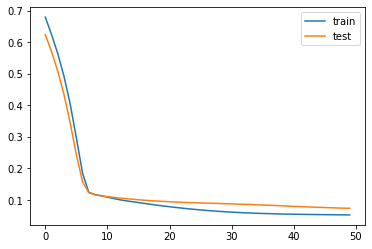

In [517]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(5))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [518]:
yhat = model.predict(test_X)  # pressure prediction
yhat.shape

(8030, 5)

In [515]:
values.shape

(8784, 5)

In [523]:
pressure_test_pred = []
pred = np.full((test_X.shape[0], values.shape[1]), 0.)
for y in yhat.T:
    pred[:, -1] = y
    pressure_test_pred.append(scaler.inverse_transform(pred)[:, -1])
pressure_test_pred = np.array(pressure_test_pred)

In [531]:
pressure_test_pred[:, 0]

array([619.2528949 , 619.17082529, 619.0165881 , 619.10638595,
       618.87689308])

In [528]:
pred[:, 4] = test_y[:, 0]
pressure_test_value = scaler.inverse_transform(pred)[:, -1]

In [533]:
# calculate RMSE
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(pressure_test_pred[0, :], pressure_test_value))
print('Test Pressure RMSE: %.3f' % rmse)

Test Pressure RMSE: 1.027


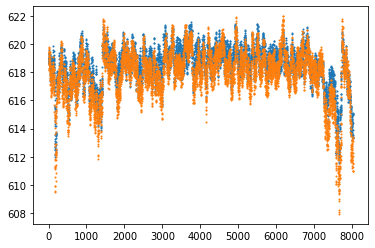

In [536]:
x = np.arange(0, len(pressure_test_value), 1.)
plt.scatter(x, pressure_test_pred[0, :], s=1, label='Prediction')
plt.scatter(x, pressure_test_value, s=1, label='Truth')
plt.legend()
plt.show()

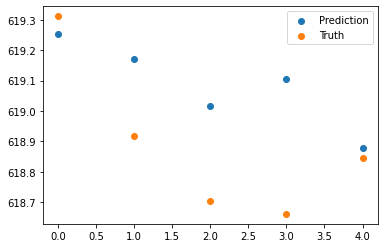

In [541]:
# 5 minutes predictions
plt.scatter(x[0:5], pressure_test_pred[:, 0], label='Prediction')
plt.scatter(x[0:5], pressure_test_value[0:5], label='Truth')
plt.legend()
plt.show()